In [1]:
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import os
from keras.utils import to_categorical
from keras.utils import image_dataset_from_directory
from imblearn.under_sampling import RandomUnderSampler

from keras import Sequential
from keras import layers

from keras import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.layers import BatchNormalization

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import seaborn as sns

from sklearn.metrics import accuracy_score

In [3]:
# Postavljanje putanje do dataset-a
data_trainset_path = "C:\\Users\\Teodora\\NM Projekat 1\\asl_alphabet_train\\asl_alphabet_train"
data_testset_path = "C:\\Users\\Teodora\\NM Projekat 1\\asl_alphabet_test\\asl_alphabet_test"

# Postavljanje veličine slika (img_size) koje će se koristiti u dataset-u
img_size = (64, 64)

# Postavljanje veličine batch-a (batch_size) za trening i validaciju
batch_size = 64

## Opis problema:

Dataset predstavlja kolekciju slika alfabeta američkog znakovnog jezika (American Sign Language - ASL), koje su razvrstane u 29 foldera koji predstavljaju različite klase. Ovaj dataset ima za cilj rešavanje problema klasifikacije znakova znakovnog jezika. 

### Ulazni podaci:

Slike alfabeta američkog znakovnog jezika dimenzija 200x200 piksela.
Ukupno 87,000 slika u trening skupu.

### Klase:

Postoji 29 klasa, pri čemu 26 klasa predstavljaju slova od A do Z.
Dodatno, postoje 3 posebne klase:
SPACE: Za znak za razmak.
DELETE: Za znak za brisanje.
NOTHING: Za situaciju kada nema znaka.

### Cilj problema:

Cilj je razviti model za klasifikaciju znakova znakovnog jezika, gde svaka klasa predstavlja određeni znak ili situaciju.
Model treba da prepoznaje različite znakove znakovnog jezika na osnovu slika.

### Primena u stvarnom vremenu:

Klase SPACE, DELETE i NOTHING posebno korisne u aplikacijama u stvarnom vremenu i klasifikaciji. To sugeriše na moguće primene u interaktivnim sistemima prepoznavanja znakovnog jezika.

### Testni skup:

Test skup sadrži 29 slika.

In [4]:
# Kreiranje trening dataset-a koristeći slike iz direktorijuma data_trainset_path
Xtrain = image_dataset_from_directory(data_trainset_path, subset='training', validation_split=0.2, image_size=img_size, batch_size=batch_size, seed=123)

# Kreiranje validacionog dataset-a koristeći slike iz direktorijuma data_trainset_path
Xval = image_dataset_from_directory(data_trainset_path, subset='validation', validation_split=0.2, image_size=img_size, batch_size=batch_size, seed=123)

# Kreiranje test dataset-a koristeći slike iz direktorijuma data_trainset_path
Xtest = image_dataset_from_directory(data_testset_path, labels='inferred',image_size=img_size, batch_size=batch_size, seed=123)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
Found 29 files belonging to 29 classes.


## Podela podataka:

### Trening skup (Training set):

Koristi se za treniranje modela, tj. optimizaciju težina mreže kako bi se model prilagodio podacima.
Trening skup obično čini veći deo dostupnih podataka (npr. 80% podataka).

### Validacioni skup (Validation set):

Koristi se za odabir i podešavanje hiperparametara modela, kao i praćenje performansi tokom treniranja.
Validacioni skup je manji od trening skupa i može činiti oko 10-20% dostupnih podataka.

### Test skup (Test set):

Koristi se za konačnu evaluaciju performansi modela na podacima koje model nije video tokom treninga. U nasem slucaju imamo dataset od 29 slika koje ce mo koristiti za testiranje modela.

Generalizacija: Podela na trening, validacioni i test skup pomaže modelu da generalizuje dobro na novim, nepoznatim podacima.
Sprečavanje preobucavanja: Validacioni skup pomaže u praćenju performansi na neviđenim podacima tokom treninga, sprečavajući preobucavanje modela trening podacima.

Train-Validation Split: Trening skup se deli na trening i validacioni skup. Podela se obično vrši nasumično, ali zadržava ravnotežu klasa kako bi model bio robusniji.

Data Augmentation: Mi smo koristili data argumentation kako bi se trening skup dodatno proširuje tehnikama uvećanja podataka kako bi se modelu pružilo više raznolikih primera.

In [5]:
# Dohvatanje imena klasa (etiketa) iz trening dataset-a (Xtrain)
classes = Xtrain.class_names

# Ispisivanje imena klasa koje se koriste u dataset-u
print('Klase su:', classes)

Klase su: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


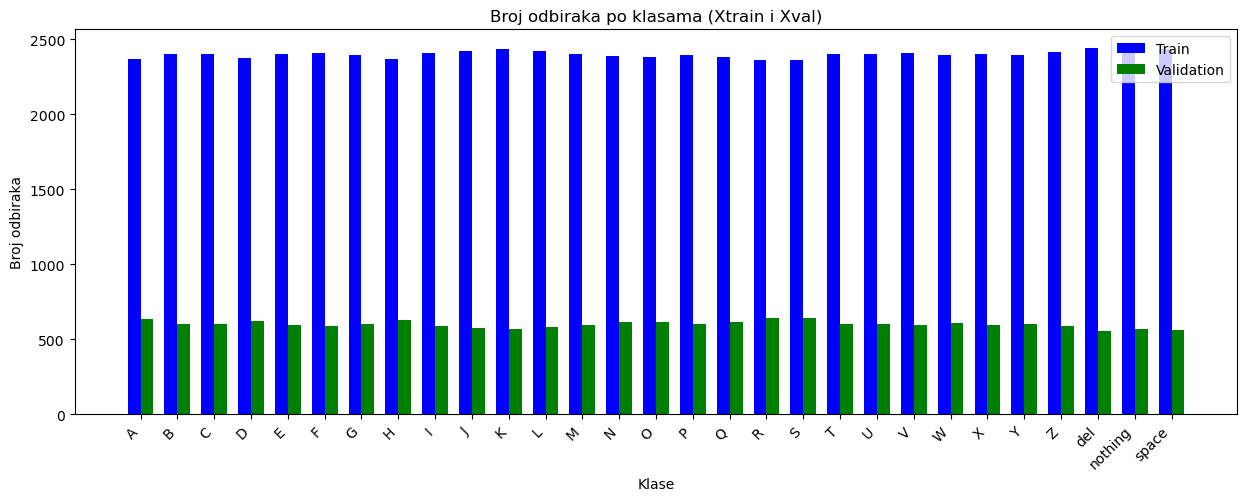

Broj podataka po klasama u Xtrain:
A: 2366
B: 2399
C: 2401
D: 2375
E: 2402
F: 2408
G: 2395
H: 2370
I: 2410
J: 2425
K: 2432
L: 2421
M: 2403
N: 2387
O: 2384
P: 2397
Q: 2382
R: 2359
S: 2360
T: 2400
U: 2401
V: 2406
W: 2392
X: 2402
Y: 2397
Z: 2412
del: 2444
nothing: 2432
space: 2438

Broj podataka po klasama u Xval:
A: 634
B: 601
C: 599
D: 625
E: 598
F: 592
G: 605
H: 630
I: 590
J: 575
K: 568
L: 579
M: 597
N: 613
O: 616
P: 603
Q: 618
R: 641
S: 640
T: 600
U: 599
V: 594
W: 608
X: 598
Y: 603
Z: 588
del: 556
nothing: 568
space: 562


In [6]:
# Prikazivanje broja odbiraka po klasama za Xtrain i Xval
plt.figure(figsize=(15, 5))

# Inicijalizacija niza za brojanje odbiraka po klasama
class_counts_train = np.zeros(len(classes))
class_counts_val = np.zeros(len(classes))

# Iteracija kroz batch-ove u trening datasetu (Xtrain)
for images, labels in Xtrain:
    # Dobijanje jedinstvenih klasa i broja odbiraka za svaku klasu u trenutnom batch-u
    unique, counts = np.unique(labels, return_counts=True)
    
    # Akumuliranje broja odbiraka po klasama
    class_counts_train[unique] += counts

# Iteracija kroz batch-ove u validacionom datasetu (Xval)
for images, labels in Xval:
    # Dobijanje jedinstvenih klasa i broja odbiraka za svaku klasu u trenutnom batch-u
    unique, counts = np.unique(labels, return_counts=True)
    
    # Akumuliranje broja odbiraka po klasama
    class_counts_val[unique] += counts

# Prikazivanje bar grafika sa brojem odbiraka po klasama iz trening i validacionog skupa
bar_width = 0.35
index = np.arange(len(classes))
plt.bar(index, class_counts_train, width=bar_width, label='Train', color='blue')
plt.bar(index + bar_width, class_counts_val, width=bar_width, label='Validation', color='green')

# Postavljanje naslova i oznaka na x i y osi
plt.title('Broj odbiraka po klasama (Xtrain i Xval)')
plt.xlabel('Klase')
plt.ylabel('Broj odbiraka')

# Postavljanje legende
plt.legend()

# Rotiranje oznaka na x osi radi bolje čitljivosti
plt.xticks(index + bar_width / 2, classes, rotation=45, ha='right')

# Prikazivanje grafika
plt.show()

# Ispis broja podataka po klasama
print("Broj podataka po klasama u Xtrain:")
for class_name, count in zip(classes, class_counts_train):
    print(f"{class_name}: {int(count)}")

print("\nBroj podataka po klasama u Xval:")
for class_name, count in zip(classes, class_counts_val):
    print(f"{class_name}: {int(count)}")


## Balansiranost klasa:

Balansiranost podataka odnosi se na ravnotežu između različitih klasa u skupu podataka. U kontekstu problema klasifikacije, balansirani skup podataka ima približno jednaki broj odbiraka za svaku klasu. Ova ravnoteža je važna jer pomaže modelu da nauči karakteristike svake klase podjednako, što dovodi do bolje generalizacije i donošenja pouzdanih predviđanja na novim, neviđenim podacima.

Ako skup podataka nije balansiran, to može dovesti do problema prilikom treniranja modela, posebno kada su neke klase zastupljene mnogo više ili manje nego druge. Na primer, ako imamo klasifikaciju na dva različita izlaza (klase) i 95% podataka pripada klasi A, a samo 5% klasi B, model može biti pristrasnost i imati tendenciju da često predviđa klasu A, bez obzira na stvarne karakteristike podataka.

Balansiranje podataka može se postići različitim tehnikama, uključujući oversampling (povećanje uzorka manje zastupljenih klasa), undersampling (smanjenje uzorka prebrojenih klasa).

Većina klasa ima sličan broj podataka u Xtrain i Xval skupovima.
Razlike između najmanjeg i najvećeg broja podataka po klasama nisu izražene, a većina se kreće u opsegu od 2300 do 2450.
Razlike su posebno male za većinu slova A-Z, što su klase koje predstavljaju pojedinačna slova abecede.
S obzirom na ove činjenice, možemo reći da su podaci balansirani. 

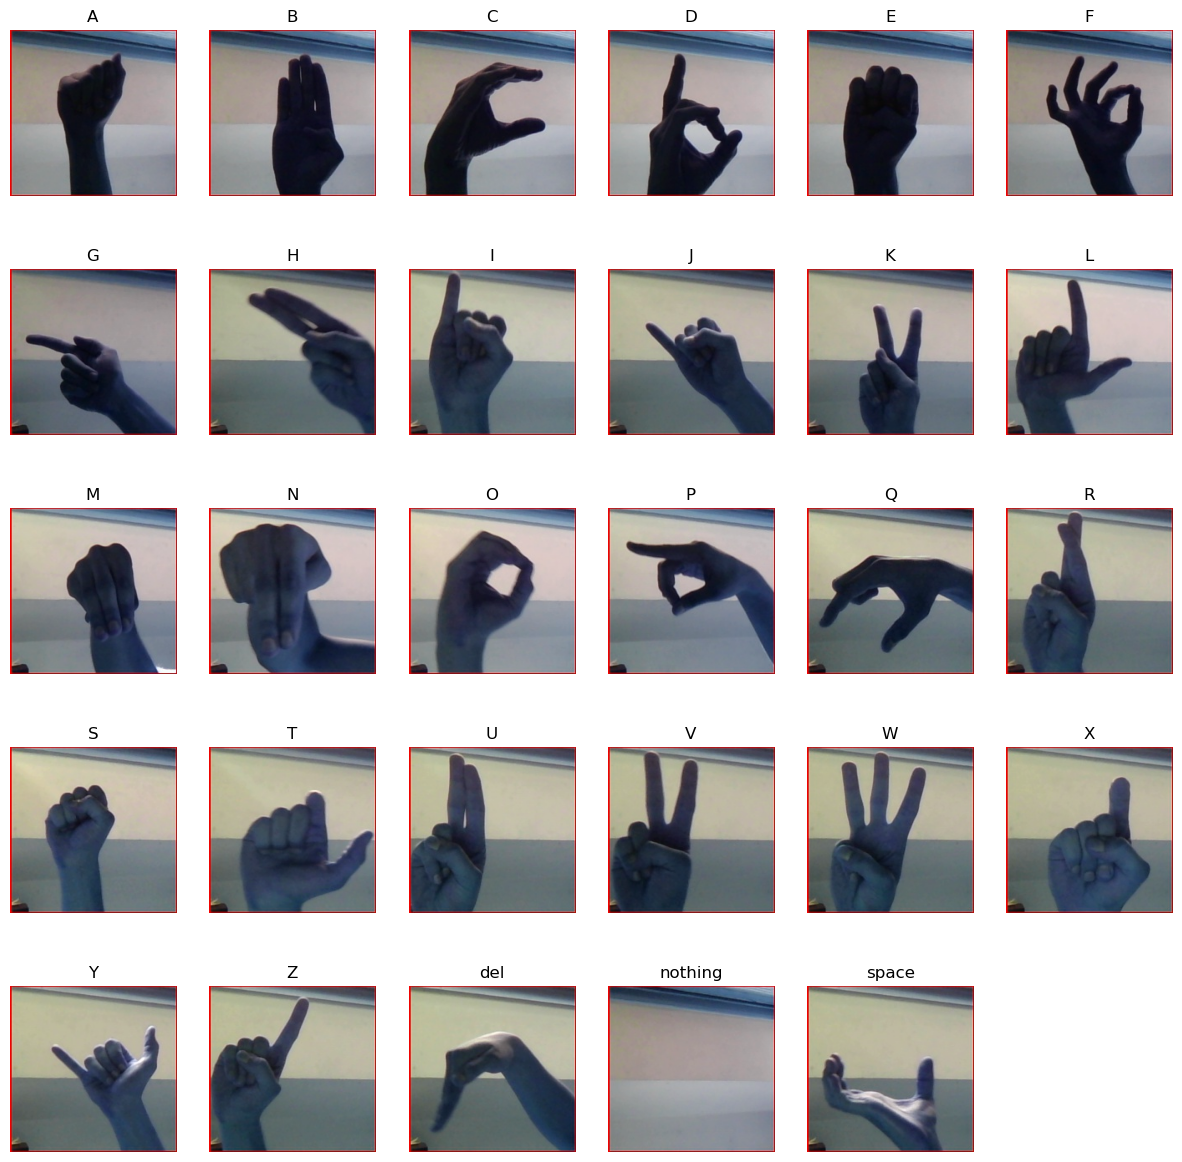

In [7]:
# Prikazivanje jednog primera iz svake klase

# Definisanje broja primera koje želite prikazati iz svake klase
num_examples = 1 

# Iteracija kroz klase
plt.figure(figsize=(15, 15))

for i, class_name in enumerate(classes):
    # Formiranje putanje do direktorijuma koji sadrži slike određene klase
    class_path = os.path.join(data_trainset_path, class_name)

    # Lista za skladištenje putanja do slika određene klase
    class_images = []

    # Iteracija kroz sve slike u datom direktorijumu klase
    for img_name in os.listdir(class_path):
        # Formiranje putanje do slike kombinacijom imena slike i putanje do direktorijuma
        img_path = os.path.join(class_path, img_name)

        # Dodavanje formirane putanje do slike u listu class_images
        class_images.append(img_path)

        # Ako smo dostigli željeni broj primera (num_examples), prekidamo iteraciju
        if len(class_images) == num_examples:
            break

    # Priprema za prikazivanje slike
    plt.subplot(5, 6, i + 1)

    # Prikazivanje jedne slučajno izabrane slike iz liste class_images
    # Funkcija random.choice se koristi za slučajan odabir jedne slike iz liste putanja
    plt.imshow(cv2.imread(random.choice(class_images)))

    # Dodavanje naslova slici sa nazivom trenutne klase
    plt.title(class_name)

    # Isključivanje oznaka osa za bolju estetiku
    plt.axis('off')

plt.show()

In [8]:
# Definisanje tehnike uvećanja podataka
data_augmentation = Sequential(
    [
        # Horizontalna refleksija slike (levo-desno)
        layers.RandomFlip("horizontal", input_shape=(img_size[0], img_size[1], 3)),
        
        # Rotacija slike za nasumičan ugao do 0.25
        layers.RandomRotation(0.25),
        
        # Zumiranje slike za nasumičan faktor do 0.1
        layers.RandomZoom(0.1),
    ]
)

C:\Users\Teodora\AppData\Local\Temp\ipykernel_8316\4187139997.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, int(N/2) + 1, 1)


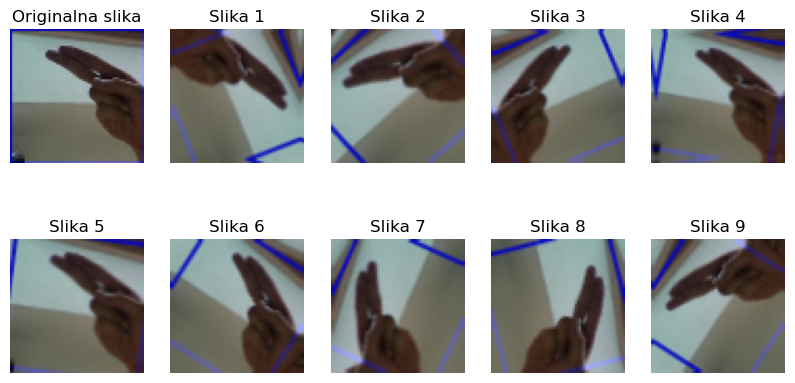

In [9]:
# Broj slika koje prikauzujem
N = 9

# Uzimanje jednog batch-a podataka iz trening skupa
# Xtrain.take(1) se koristi da biste uzeli jedan batch podataka iz vašeg trening skupa podataka.
# img su slike, lab su oznake (etikete) tih slika
for img, lab in Xtrain.take(1):
    plt.figure(figsize=(10, 5))
    plt.title(classes[lab[0]])

    # Prikazivanje originalne slike
    plt.subplot(2, int(N/2) + 1, 1)
    plt.imshow(img[0].numpy().astype('uint8'))
    plt.axis('off')
    plt.title('Originalna slika')

    # Prikazivanje slika generisanih pomoću data augmentation-a
    for i in range(1, N+1):
        aug_img = data_augmentation(img)
        plt.subplot(2, int(N/2) + 1, i+1)
        plt.imshow(aug_img[0].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(f'Slika {i}')

    plt.show()

In [10]:
# Broj klasa u vašem skupu podataka
num_classes = len(classes)

# Kreiranje modela
model = Sequential([
    
    # Tehnika uvećanja podataka
    data_augmentation,
    
    # Normalizacija slika
    layers.Rescaling(1./255, input_shape=(64, 64, 3)),
    
    # Konvolucioni slojevi
    layers.Conv2D(16, 3, padding='same', strides=(1,1), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', strides=(1,1), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', strides=(1,1), activation='relu'),
    layers.MaxPooling2D(),
    
    # Dropout sloj za smanjenje preobucavanja
    layers.Dropout(0.2),
    
    # Ravnanje (flatten) prema ulazu u potpuno povezan sloj
    layers.Flatten(),
    
    # Potpuno povezan sloj sa 128 neurona i ReLU aktivacijom
    layers.Dense(128, activation='relu'),
    
    # Dodavanje BatchNormalization sloja(Skaliranje podataka)
    # Ovaj sloj vrši normalizaciju izlaza iz prethodnog sloja tokom treninga.
    # On koristi srednju vrednost i standardnu devijaciju trenutnog batch-a kako bi normalizovao izlaze.
    #BatchNormalization(),
    
    # Dropout sloj za smanjenje preobucavanja
    layers.Dropout(0.2),
    
    # Potpuno povezan izlazni sloj sa softmax aktivacijom za klasifikaciju
    layers.Dense(num_classes, activation='softmax')
])

# Ispisivanje arhitekture modela
model.summary()

# Kompilacija modela
model.compile(
    
    # Optimizator
    optimizer='adam',
    
    # Funkcija gubitka za klasifikaciju
    loss=SparseCategoricalCrossentropy(),  
    
    # Merenje tačnosti modela
    metrics='accuracy'  
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                  

## Arhitektura modela

### Ulazni podaci: 
Model očekuje ulazne podatke dimenzija 64x64 piksela sa tri kanala (RGB slike).

### Normalizacija: 
Prvi sloj modela je sloj normalizacije (rescaling). Ovaj sloj vrši jednostavno skaliranje ulaznih piksela na opseg [0, 1], što može poboljšati konvergenciju modela.

### Konvolutivni slojevi:
Model koristi tri konvolutivna sloja (conv2d) sa odgovarajućim brojem filtera(matrica težina) (16, 32, 64). Konvolucija se primenjuje kako bi se detektovali različiti nivoi apstrakcije u podacima.

### Slojevi sažimanja: 
Nakon svakog konvolutivnog sloja sledi sloj sažimanja (max_pooling2d) koji smanjuje dimenzije prostora i broj parametara. Ovo pomaže modelu da bolje generalizuje i smanjuje računsku složenost.

### Dropout sloj: 
Dodat je dropout sloj kako bi se izbeglo preprilagođavanje modela tokom treninga. Dropout slučajno isključuje neke neurone tokom svake epohe, što doprinosi generalizaciji.

Dropout sloj nasumično isključuje (postavlja na nulu) određeni procenat neurona tokom svake epohe treninga. Ovaj postupak se vrši nezavisno za svaki unos. Isključivanje neurona tokom treninga prisiljava mrežu da ne zavisi previše od određenih neurona.
Ova tehnika pomaže u smanjenju prilagođavanja tako što sprečava da se model previše specijalizuje za trening podatke.
Kada se model primeni na nove podatke (podaci iz test skupa), neuroni koji su bili isključeni tokom treninga sada mogu biti aktivirani, što doprinosi boljoj generalizaciji.

### Flatten sloj: 
Nakon poslednjeg sloja sažimanja, koristi se sloj za ravnanje (flatten) kako bi se pripremili podaci za potpuno povezane slojeve. Potpuno povezani slojevi očekuju ulaz u obliku vektora, pa je Flatten sloj neophodan korak kako bi se omogućila komunikacija između konvolucione i potpuno povezane putanje mreže.

### Potpuno povezani slojevi: 
Model sadrži dva potpuno povezana sloja (dense) sa 128 i 29 neurona, što odgovara broju klasa u našem skupu podataka (29 klasa). Poslednji sloj koristi softmax aktivaciju i predstavlja izlaz modela.

Koristili smo ReLU (Rectified Linear Unit) aktivacionu funkciju u potpuno povezanim slojevima kako bi se model osposobio za učenje nelinearnih atributa. Za sve pozitivne vrednosti ulaza, ReLU funkcija vraća samu vrednost, dok za negativne vrednosti vraća nulu. Matematički, ReLU se definiše kao f(x)=max(0,x).

Poslednji sloj koristi softmax aktivaciju. Softmax se često koristi u klasifikacionim zadacima jer pretvara izlaze neurona u verovatnoće, čime se omogućava lakše tumačenje rezultata.

### Parametri modela: 
Model ukupno ima 551,741 parametra. Ovo su parametri koje će model optimizovati tokom treninga.

## Adam optimizator:
Adam automatski prilagođava stopu učenja za svaki parametar pojedinačno, što može značajno poboljšati brzinu konvergencije.

### Learning rate (Stopa učenja):

Stopa učenja određuje korak koji optimizator preduzima u pravcu minimizacije funkcije gubitka. Optimizacija se postiže iterativnim ažuriranjem težina modela u smeru koji minimizuje gubitak.
Vrednost stopa učenja igra ključnu ulogu u efikasnosti treniranja. Ako je stopa učenja prevelika, može doći do oscilacija ili problema divergencije. Ako je premala, trening može biti spor, a model može zapasti u lokalne minimume.

Adam prilagođava stopu učenja za svaki parametar ponaosob, koristeći informacije o prvom momentu gradijenta i drugom momentu gradijenta za svaki parametar. Ova adaptacija omogućava efikasno treniranje modela sa složenim funkcijama gubitka i menja se tokom vremena kako bi se prilagodila karakteristikama podataka.

## Funkcija gubitka (Loss Function):

Funkcija gubitka (loss function) se koristi za merenje razlike između stvarnih vrednosti ciljne promenljive i predviđenih vrednosti koje generiše model. Cilj je minimizovati ovu razliku tokom treninga kako bi se model naučio što preciznije. 

Sparse Categorical Crossentropy se često koristi kao funkcija gubitka u višeklasnoj klasifikaciji, gde svaki ulaz može pripadati tačno jednoj klasi. Ova funkcija gubitka meri razliku između stvarnih distribucija klasa i distribucija predviđenih od strane modela. Razlika između Sparse Categorical Crossentropy i Categorical Crossentropy je u načinu predstavljanja ciljnih podataka. Sparse Categorical Crossentropy koristi indekse ciljnih klasa (npr. 0, 1, 2), dok Categorical Crossentropy koristi one-hot kodiranje ciljnih klasa. Sparse Categorical Crossentropy se često koristi kada ciljne vrednosti predstavljaju indekse klasa, što je uobičajeno kod problema višeklasne klasifikacije.

In [28]:
# Definisanje tehnike zaštite od preobučavanja

# EarlyStopping: Prekida obučavanje ako se gubitak na validacionom skupu ne poboljšava tokom određenog broja epoha
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Obučavanje modela uz primenu tehnika zaštite od preobučavanja
history = model.fit(
    Xtrain,
    epochs=10,
    batch_size=64, 
    validation_data=Xval,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
1088/1088 [==============================] - 345s 301ms/step - loss: 2.4934 - accuracy: 0.2537 - val_loss: 1.5622 - val_accuracy: 0.5037
Epoch 2/10
1088/1088 [==============================] - 416s 382ms/step - loss: 1.4334 - accuracy: 0.5281 - val_loss: 0.9841 - val_accuracy: 0.6744
Epoch 3/10
1088/1088 [==============================] - 314s 288ms/step - loss: 1.0748 - accuracy: 0.6319 - val_loss: 0.7319 - val_accuracy: 0.7517
Epoch 4/10
1088/1088 [==============================] - 322s 296ms/step - loss: 0.8806 - accuracy: 0.6959 - val_loss: 0.5472 - val_accuracy: 0.8239
Epoch 5/10
1088/1088 [==============================] - 318s 292ms/step - loss: 0.7579 - accuracy: 0.7349 - val_loss: 0.4056 - val_accuracy: 0.8698
Epoch 6/10
1088/1088 [==============================] - 311s 285ms/step - loss: 0.6798 - accuracy: 0.7628 - val_loss: 0.3961 - val_accuracy: 0.8657
Epoch 7/10
1088/1088 [==============================] - 480s 441ms/step - loss: 0.6029 - accuracy: 0.7886 - val_

## Preobucavanje:

Preobučavanja neuralne mreže podrazumeva da mreža gubi mogućnost generalizacije podataka, tj. da podatke nad kojima se trenira
nauči jako dobro, ali to znanje ne može da podjednsko dobro iskoristi nad podacima koje do tada nije videla. Do preobučavanja može doći ukoliko je model previše kompleksan (ima dosta težina koje mogu da skupljaju znanje), ili ukoliko se model
trenira dovoljno dugo tako da mreža ima vremena da precizno podesi težinske faktore. Preobučavanje se manifestuje tako što neuralna mreža daje dobre rezultate na trening skupu, a na test skupu se dobija greška koja je značajno veća.

## Rano zaustavljanje:

Rano zaustavljanje je tehnika sprečavanja preobučavanja koja podrazumeva da se obučavanje neuralne mreže zaustavi kada greška na
podacima koje neuralne mreža nije videla krene da raste.
Ova metoda podrazumeva da se skup podataka podeli na skup podataka za trening i skup podataka za validaciju neuralne mreže. Tokom treniranja, mreži se prosleđuju oba skupa, i paralelno se gleda greška klasifikacije na njima. Tokom treniranja greška na trening skupu će konstantno da opada, dok će greška na validacionom skupu u jednom trenutku krenuti da raste. Taj trenutak predstavlja trenutak ranog zaustavljanja.


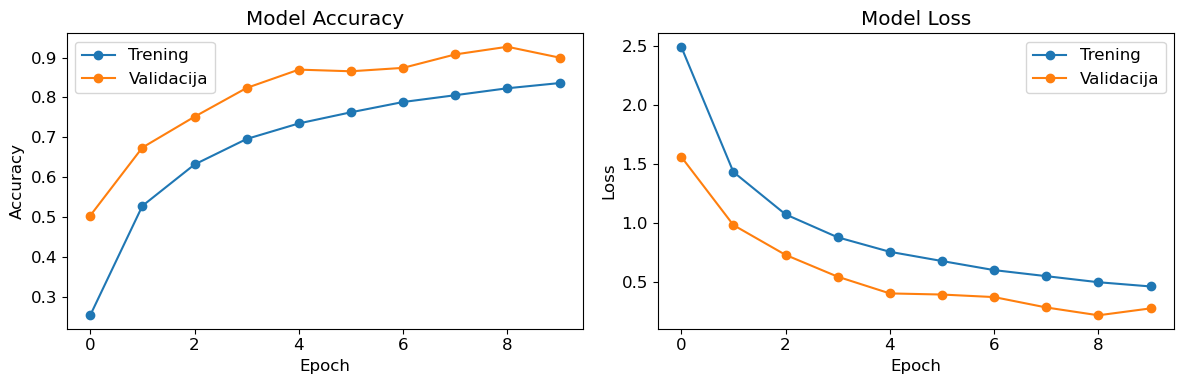

In [29]:
# Grafik performanse neuralne mreže kroz epohe obučavanja nad trening i validacionom skupu
plt.figure(figsize=(12, 4))

# Accuracy grafikon
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Trening', marker='o')
plt.plot(history.history['val_accuracy'], label='Validacija', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafikon
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Trening', marker='o')
plt.plot(history.history['val_loss'], label='Validacija', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Komentar:

Kroz epohe, praćenjem tačnosti i gubitka na trening i validacionom skupu, možemo pratiti kako se model ponaša tokom treniranja. Porast tačnosti i smanjenje gubitka na trening skupu sugeriše na to da model uči i prilagođava se trening podacima. Prisutnost te pojave ukazuje na to da model generalizuje dobro na trening skupu.

U ovom slučaju, primenjivanjem tehnike rane zaustavljanja (early stopping), sprečavamo prekomerno prilagođavanje modela trening podacima. Ako bi došlo do preobučavanja, očekivali bismo da se tačnost na trening skupu povećava dok se tačnost na validacionom skupu smanjuje, što bi rezultiralo porastom gubitka na validacionom skupu. U našem slučaju, odsustvo tog trenda ukazuje na to da model još uvek nije preobučen u okviru 10 epoha.

Rano zaustavljanje omogućava automatsko prekidanje treniranja kada se prestane sa unapređenjem performansi na validacionom skupu, čime se sprečava gubitak vremena i resursa na nepotrebnom treniranju i poboljšava efikasnost modela.

Broj 1088 predstavlja broj koraka (batches) koje je model prošao tokom jedne epohe. Svaki korak uključuje obradu jednog batch-a podataka.

In [30]:
# Inicijalizacija praznih nizova za čuvanje predviđanja i stvarnih oznaka na trening skupu
train_predictions = np.array([])
train_labels = np.array([])

# Iteracija kroz trening skup
for img, lab in Xtrain:
    
    # Dobijanje predviđanja modela za trenutni batch slika
    train_prediction = model.predict(img, verbose=0)
    
    # Izdvajanje indeksa klase sa najvećom verovatnoćom (argmax)
    train_prediction = np.argmax(train_prediction, axis=1)
    
    # Dodavanje predviđenih oznaka u niz train_predictions
    train_predictions = np.append(train_predictions, train_prediction)
    
    # Dodavanje stvarnih oznaka u niz train_labels
    train_labels = np.append(train_labels, lab)

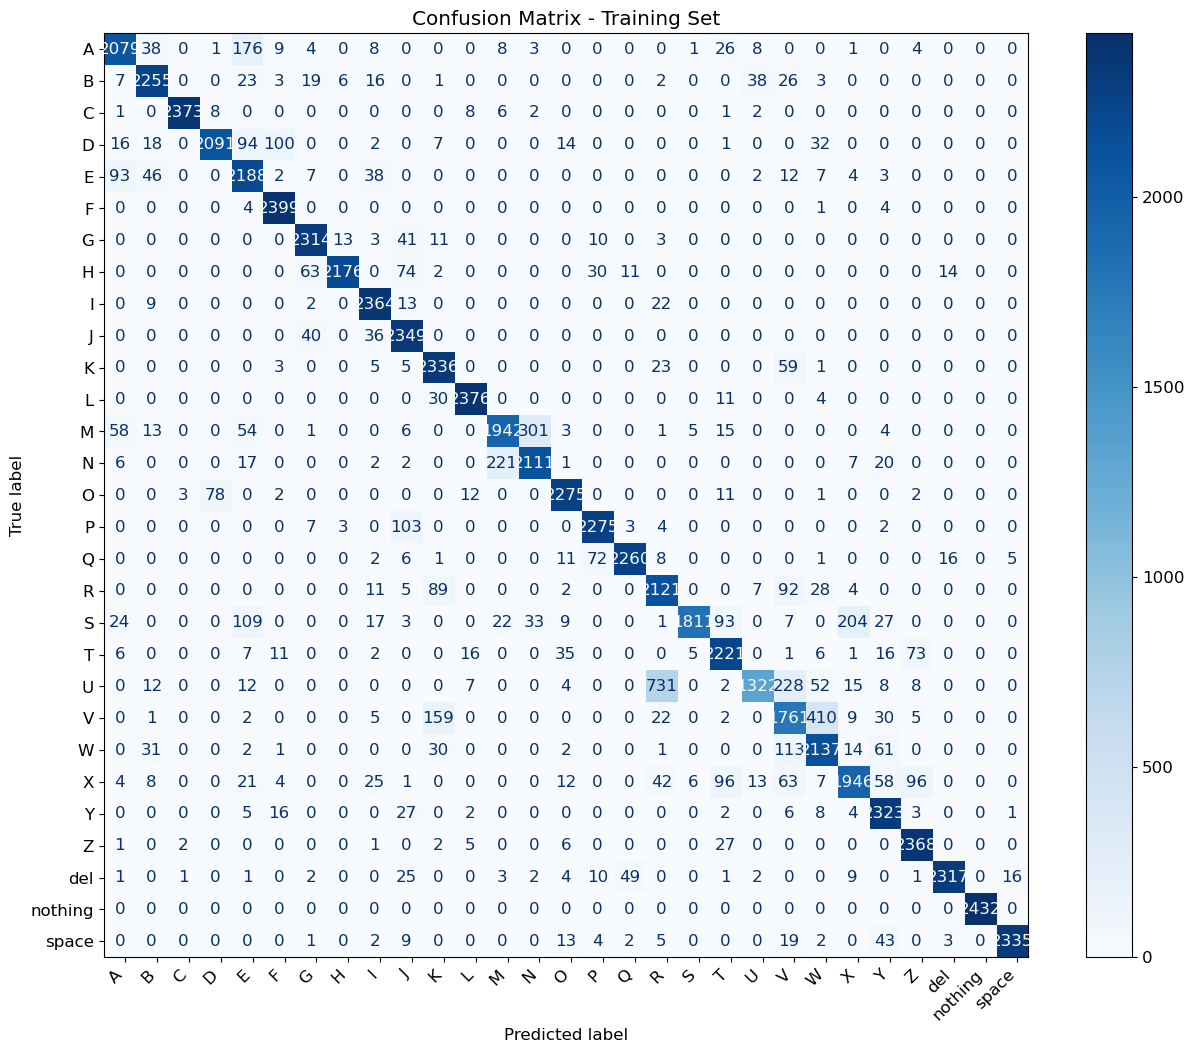

In [31]:
# Matrica konfuzije za trening skup
conf_matrix_train = confusion_matrix(train_labels, train_predictions)
conf_matrix_display_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=classes)

# Povećanje veličine teksta u matrici konfuzije
plt.rcParams['font.size'] = 12

# Podešavanje veličine slika (uključujući matricu konfuzije)
plt.figure(figsize=(15, 12))

# Prikazivanje matrice konfuzije sa većim razmakom između oznaka
conf_matrix_display_train.plot(cmap='Blues', values_format='d', ax=plt.gca())  

# Postavljanje naslova
plt.title('Confusion Matrix - Training Set')

# Rotiranje oznaka na x osi radi bolje čitljivosti
plt.xticks(index + bar_width / 2, classes, rotation=45, ha='right')

# Prikazivanje matrice konfuzije
plt.show()

In [32]:
# Računanje tačnosti na trening skupu
trening_accuracy = accuracy_score(train_labels, train_predictions)

# Ispisivanje tačnosti
print(f'Tačnost na trening skupu: {trening_accuracy * 100:.2f}%')

Tačnost na trening skupu: 90.89%


## Matrica konfuzije na trening skupu:

Glavna dijagonala predstavlja tačno klasifikovane instance po klasama. Svaki element (i, i) na glavnoj dijagonali označava koliko je tačno instanci klase i klasifikovano. Ovi elementi pružaju uvid u tačnost modela po svakoj klasi. Elementi izvan glavne dijagonale ukazuju na netačno klasifikovane instance. Element (i, j) gde je i ≠ j pokazuje koliko instanci klase i je pogrešno klasifikovano kao klasa j.

In [34]:
# Inicijalizacija praznih nizova za čuvanje predviđanja i stvarnih oznaka na test skupu
test_predictions = np.array([])
test_labels = np.array([])

# Iteracija kroz test skup
for img, lab in Xtest:
    
    # Dobijanje predviđanja modela za trenutni batch slika
    test_prediction = model.predict(img, verbose=0)
    
    # Izdvajanje indeksa klase sa najvećom verovatnoćom (argmax)
    test_prediction = np.argmax(test_prediction, axis=1)
    
    # Dodavanje predviđenih oznaka u niz test_predictions
    test_predictions = np.append(test_predictions, test_prediction)
    
    # Dodavanje stvarnih oznaka u niz test_labels
    test_labels = np.append(test_labels, lab)

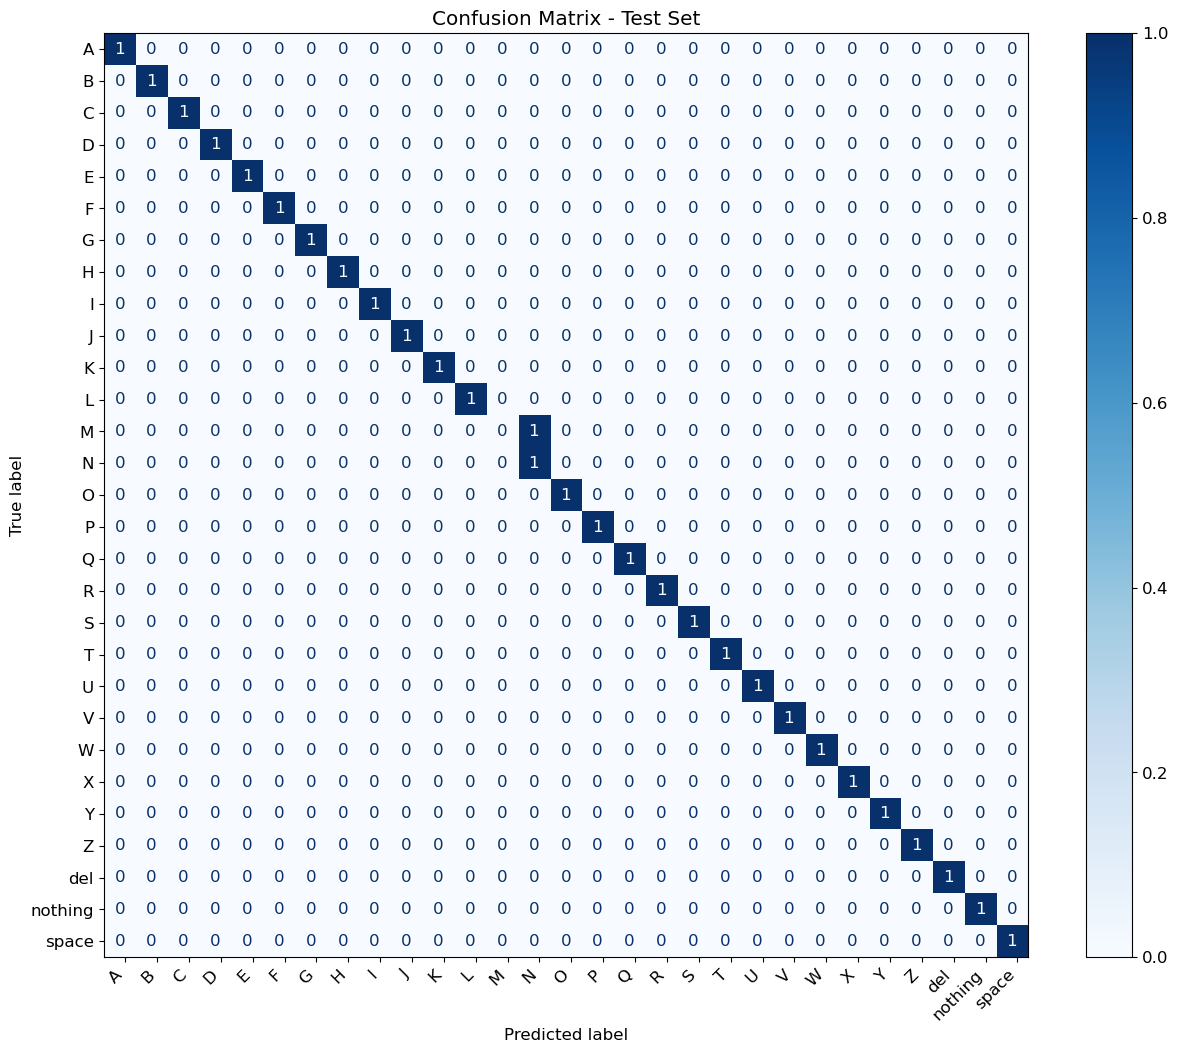

In [35]:
# Matrica konfuzije za test skup
conf_matrix_test = confusion_matrix(test_labels, test_predictions)
conf_matrix_display_test = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=classes)

# Povećanje veličine teksta u matrici konfuzije
plt.rcParams['font.size'] = 12

# Podešavanje veličine slika (uključujući matricu konfuzije)
plt.figure(figsize=(15, 12))

# Prikazivanje matrice konfuzije sa većim razmakom između oznaka
conf_matrix_display_test.plot(cmap='Blues', values_format='d', ax=plt.gca())  # ax=plt.gca() omogućava podešavanje trenutne ose

# Postavljanje naslova
plt.title('Confusion Matrix - Test Set')

# Rotiranje oznaka na x osi radi bolje čitljivosti
plt.xticks(index + bar_width / 2, classes, rotation=45, ha='right')

# Prikazivanje matrice konfuzije
plt.show()

In [40]:
# Računanje tačnosti na test skupu
test_accuracy = accuracy_score(test_labels, test_predictions)

# Ispisivanje tačnosti
print(f'Tačnost na test skupu: {test_accuracy * 100:.2f}%')

Tačnost na test skupu: 96.55%


## Matrica konfuzije na test skupu:

U test skupu imamo 29 slika koje reprezentuju 29 klasa. Iz matrice mozemo zakljuciti da je pogresno klasifikovana slika koja pripada klasi M a klasifikovana je kao klasa N. Svi ostali test primeri su uspesno klasifikovani.

In [57]:
# Inicijalizacija listi  dobro i lose klasifikovanih primera
correctly_classified_img = []
incorrectly_classified_img = []

In [64]:
# Inicijalizacija
true_labels = []
predicted_labels = []
incorrectly_classified_img = []
correctly_classified_img = []

# Iteracija kroz trening skup
for img, lab in Xtrain:
    
    # Dobijanje predviđanja modela
    predictions = model.predict(img, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Poređenje stvarnih i predviđenih labela
    for i, (true_label, predicted_class) in enumerate(zip(lab.numpy(), predicted_classes)):
        # Ako je instanca netačno klasifikovana
        if true_label != predicted_class:
            incorrectly_classified_img.append(img[i].numpy())
            true_labels.append(true_label)
            predicted_labels.append(predicted_class)
        # Ako je instanca tačno klasifikovana
        if true_label == predicted_class:
            correctly_classified_img.append(img[i].numpy())
            true_labels.append(true_label)
            

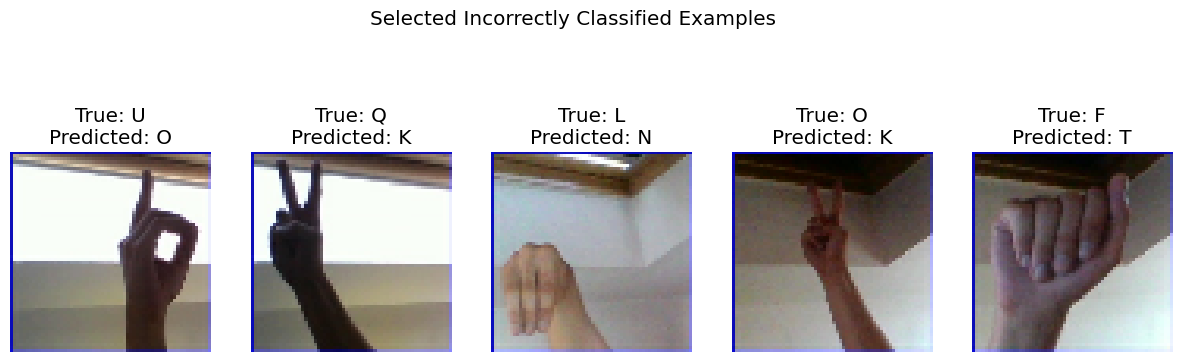

In [70]:
# Prikazivanje nasumičnih loše klasifikovanih primera
plt.figure(figsize=(15, 5))
plt.suptitle('Selected Incorrectly Classified Examples')

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(incorrectly_classified_img[i].astype(np.uint8))
    plt.title(f'True: {classes[true_labels[i]]}\nPredicted: {classes[predicted_labels[i]]}')
    plt.axis('off')
    
plt.show()    

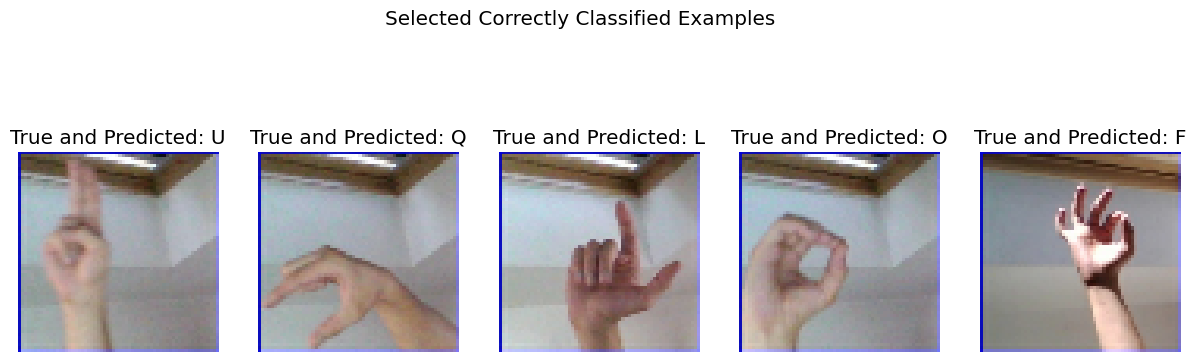

In [69]:
# Prikazivanje dobro klasifikovanih primera
plt.figure(figsize=(15, 5))
plt.suptitle('Selected Correctly Classified Examples')

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(correctly_classified_img[i].astype(np.uint8))
    plt.title(f'True and Predicted: {classes[true_labels[i]]}')
    plt.axis('off')

plt.show()